In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as rd
import statistics as stats
import math
import scipy.stats
from math import gamma
from tqdm import tqdm
import random as rd

# Modèle 1

In [2]:
data = pd.read_csv('listeria.txt', sep=',')
data.columns = ['nb_pos', 'nb_test']
new_row = {'nb_pos':0, 'nb_test':600}
data = data.append(new_row, ignore_index=True)

In [3]:
data['prob']=data["nb_pos"]/data['nb_test']
proba_constante = sum(data['nb_pos'])/sum(data['nb_test'])

- `data.nb_pos[i]` : nombre de personnes testées positives sur l'échantillon i 
- `data.nb_test[i]`: nombre de personnes testées dans l'échantillon i 
- `data.prob[i]`: probabilité empirique d'être positif sur l'étude i
- `proba_constante`: probabilité empirique d'être positif. 

In [15]:
data_wo = data[data.nb_test <=1.2e+06]
data_wo.nb_test.describe()
#print(len(data[data.nb_test >1.2e+06]))

count      90.000000
mean      333.344444
std       575.923180
min        14.000000
25%        80.000000
50%       135.500000
75%       332.000000
max      4046.000000
Name: nb_test, dtype: float64

Text(0.5, 1.0, 'Histogramme des probabilités empiriques dans chaque étude')

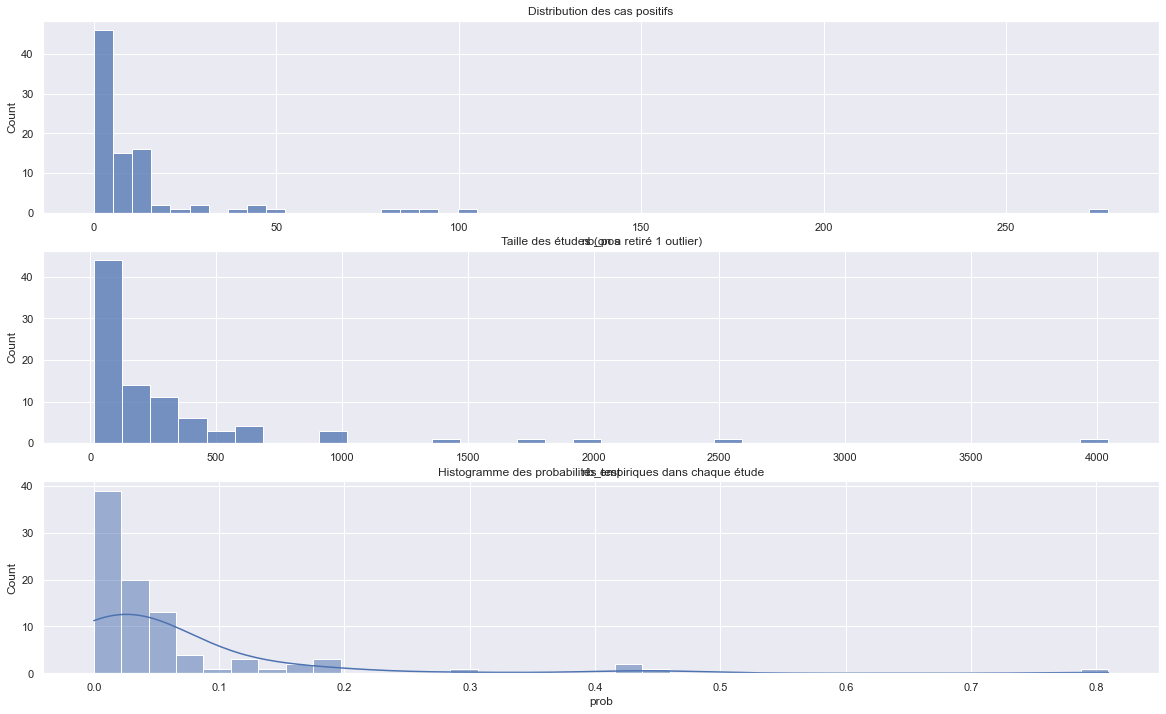

In [48]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(3,1, figsize=(20,12))

sns.histplot(data['nb_pos'], ax=ax[0],)
ax[0].set_title('Distribution des cas positifs')
#ax[0].xaxis.set_visible(False) 
sns.histplot(data_wo['nb_test'], ax=ax[1])
ax[1].set_title('Taille des études (on a retiré 1 outlier)')
#ax[1].xaxis.set_visible(False) 
sns.histplot(data['prob'], ax=ax[2], kde=True)
#ax[2].set_title('Distribution de la probabilité empirique')
#ax[2].xaxis.set_visible(False) 
plt.title('Histogramme des probabilités empiriques dans chaque étude')


In [49]:
print("premier paramètre =",sum(data['nb_pos'])+1)
print("deuxième paramètre =",sum(data['nb_test'])-sum(data['nb_pos'])+1)

premier paramètre = 1329
deuxième paramètre = 1255727


In [50]:
distr = [scipy.stats.beta.rvs(1329,1255727) for i in range(10000)]

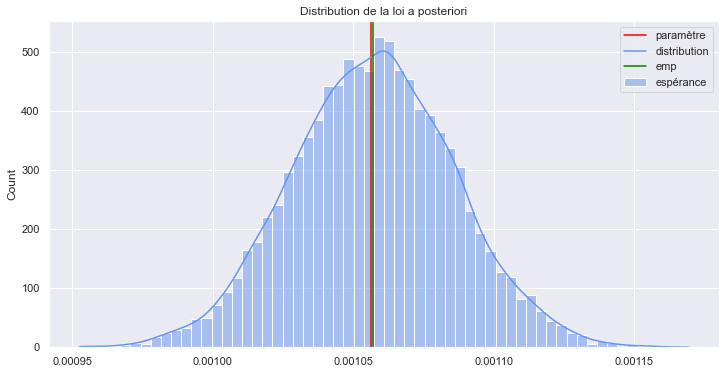

In [55]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set(style="darkgrid")
plt.axvline(proba_constante, color='red', label='paramètre')
sns.histplot(distr, kde = True, color='cornflowerblue', label='etudes')
p_esp = sum(distr)/len(distr)
plt.axvline(p_esp, color="green", label='espérance de la distribution')
plt.title("Distribution de la loi a posteriori")
plt.legend(['paramètre', 'distribution', "emp",'espérance'])


### Comparaison modèle 1 aux données

In [ ]:
sns.histplot(data['nb_pos'][data.nb_pos <= 200, kde=True)
sns.histplot(df_s[df_s <= 200].sim, color="green",alpha=0.3, kde=True)
plt.title("Distribution de la loi à priori dans l'échantillon initial")

In [61]:
l_pos = data['nb_pos'][data.nb_pos >0].tolist()
l_test= data['nb_test'][data.nb_pos > 0].tolist()
ech = [scipy.stats.beta.rvs(l_pos[i],l_test[i]) for i in range(len(l_test))]

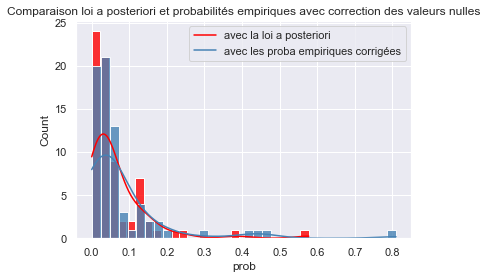

In [149]:
plt.title('Comparaison loi a posteriori et probabilités empiriques avec correction des valeurs nulles')
sns.histplot(ech, color="red", kde=True, alpha=0.8)
sns.histplot(data['prob'][data.nb_pos > 0], color="steelblue", kde=True,alpha=0.8)
plt.legend(['avec la loi a posteriori', 'avec les proba empiriques corrigées'])

# Modèle 2 (Robin)

In [75]:
def indicatrice1(x):
    if x <1 and x>0:
        return 1
    else:
        return 0

def indicatrice2(x):
    if x >0:
        return 1
    else:
        return 0


In [118]:
def gammar(x):
    if x>1:
        return (x-1)*gammar(x-1)
    else:
        return gamma(x)

In [121]:
def metropolis_within_gibbs_bis(x,sigma_1,sigma_2):
    mu=x[91]      # valeur précédente de mu
    kap=x[92]     # valeur précédente de kappa
    
    y=np.zeros(93)  #initialisation d'un vecteur y qui contiendra les valeurs à l'étape suivante
    
    for i in range(0,91):
        a = mu*kap+data['nb_pos'][i]
        b = data['nb_test'][i]-data['nb_pos'][i]+kap*(1-mu)
        y[i]=np.random.beta(a,b)
    
    z = mu + sigma_1 * np.random.randn()       # proposition pour la prochaine valeur de mu 
    
    if indicatrice1(z)==0:
        seuil_mu=0
    else:
        quantite_1=((1/gammar(kap*z))*(1/gammar(kap*(1-z))))**91
        quantite_2=((1/gammar(kap*mu))*(1/gammar(kap*(1-mu))))**91
        quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
        seuil_mu=min(1,(quantite_1*quantite_3)/quantite_2)
                                                                   
    if np.random.rand() < seuil_mu:             # on accepte z comme nouvelle valeur de mu
        y[91]=z
    
    else:
        y[91]=mu                             # on garde l'ancienne valeur de mu
    
    
    w = kap + sigma_2 * np.random.randn()         # proposition pour la prochaine valeur de kappa
    
    if indicatrice2(w)==0:
        seuil_kap=0
    else:
        quantite_1=np.exp(-0.1*91*(w-kap))
        quantite_2=((gammar(w)/gammar(w*y[91]))*(1/gammar(w*(1-y[91]))))**91
        quantite_3=((gammar(kap)/gammar(kap*y[91]))*(1/gammar(kap*(1-y[91]))))**91
        quantite_4=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(y[91]*(w-kap))
        quantite_5=(math.prod([(1-y[i]) for i in range(0,91)]))**(w-kap)
        seuil_kap=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
        
    if np.random.rand() < seuil_kap:             # on accepte w comme nouvelle valeur de kappa
        y[92]=w
    
    else:
        y[92]=kap                            # on garde l'ancienne valeur de kappa  

    
    return y, seuil_mu, seuil_kap     # on retourne le vecteur des nouvelles valeurs

In [146]:
# initialisation de notre vecteur y qui contiendra les valeurs successives de nos 93 paramètres (les 91 p_i + mu + kappa)

N = 10000
y = np.zeros((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]           # on prend les probas empiriques comme probas initiales
    
y[0,91]=0.5         # valeur initiale pour mu car mu suit une uniforme sur [0,1]
y[0,92]=10          # valeur initiale pour kappa car kappa suit une exp(0.1) donc est de moyenne 10


# generate chain
l_mu, l_kappa = [],[]
for sigma in np.linspace(0.1,3,10):
    seuil_mu=[]
    seuil_kappa=[]
    for n in tqdm(range(1, 1000)): 
        met=metropolis_within_gibbs_bis(y[n-1],sigma_1=sigma,sigma_2=sigma)
        y[n] = met[0]
        seuil_mu.append(met[1])
        seuil_kappa.append(met[2])
    l_mu.append(np.mean(seuil_mu))
    l_kappa.append(np.mean(seuil_kappa))
df = pd.DataFrame({'sigma':sigma, 'seuil_mu':l_mu, 'seuil_kappa':l_kappa})

  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-121-ac0d0879f009>:20: RuntimeWarning: invalid value encountered in double_scalars
  seuil_mu=min(1,(quantite_1*quantite_3)/quantite_2)
  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-121-ac0d0879f009>:19: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-121-ac0d0879f009>:39: RuntimeWarning: overflow encountered in double_scalars
  seuil_kap=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-121-ac0d0879f009>:35: RuntimeWarning: overflow encountered in double_scalars
  quantite_2=((gammar(w)/gammar(w*y[91]))*(1/gammar(w*(1-y[91]))))**91
<ipython-input-121-ac0d0879f009>:36: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=((gammar(kap)/gammar(kap*y[91]))*(1/gammar(kap*(1-y[91]))))**91
<ipython-input-121-ac0d08

<AxesSubplot:>

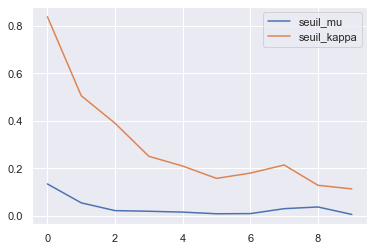

In [153]:
df['sigma']=np.linspace(0.1,3,10)
df[['seuil_mu', 'seuil_kappa']].plot()

In [154]:
df

,sigma,seuil_mu,seuil_kappa
0,0.100000,0.133974,0.838329
1,0.422222,0.054358,0.505649
2,0.744444,0.021674,0.389637
3,1.066667,0.018936,0.250387
4,1.388889,0.015332,0.209392
5,1.711111,0.008402,0.157409
6,2.033333,0.009065,0.179624
7,2.355556,0.029839,0.213817
8,2.677778,0.036967,0.128274
9,3.000000,0.005639,0.113171


In [135]:
print("moyenne =",np.mean(y[10000:,92]))          #  doit être "proche" de 10
print("variance =",np.var(y[10000:,92]))          # doit être "proche" de 100

moyenne = nan
variance = nan


Text(0.5, 1.0, 'MCMC pour mu')

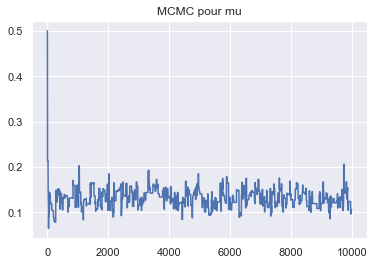

In [82]:
plt.plot(y[:,91])
plt.title("MCMC pour mu")
# MCMC trace pour mu

Text(0.5, 1.0, 'MCMC pour kappa')

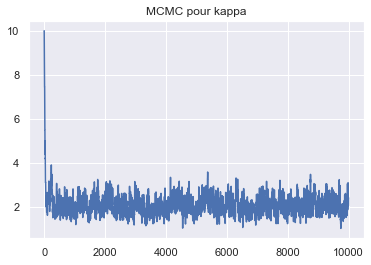

In [84]:
plt.plot(y[:,92])
plt.title("MCMC pour kappa")
# MCMC trace pour kappa

In [162]:
# réinitialisation de notre vecteur y 
N = 10000
y = np.zeros((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=5

w=np.zeros(N)
kap=np.zeros(N)
z=np.zeros(N)

for n in tqdm(range(1, 10000)):
    y[n] = metropolis_within_gibbs_bis(y[n-1],sigma_1=0.3,sigma_2=10)[0]

  0%|          | 0/9999 [00:00<?, ?it/s]<ipython-input-121-ac0d0879f009>:35: RuntimeWarning: overflow encountered in double_scalars
  quantite_2=((gammar(w)/gammar(w*y[91]))*(1/gammar(w*(1-y[91]))))**91
<ipython-input-121-ac0d0879f009>:39: RuntimeWarning: invalid value encountered in double_scalars
  seuil_kap=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
<ipython-input-121-ac0d0879f009>:20: RuntimeWarning: invalid value encountered in double_scalars
  seuil_mu=min(1,(quantite_1*quantite_3)/quantite_2)
<ipython-input-121-ac0d0879f009>:39: RuntimeWarning: overflow encountered in double_scalars
  seuil_kap=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
  0%|          | 38/9999 [00:00<01:10, 140.96it/s]<ipython-input-121-ac0d0879f009>:36: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=((gammar(kap)/gammar(kap*y[91]))*(1/gammar(kap*(1-y[91]))))**91
<ipython-input-121-ac0d0879f009>:37: RuntimeWarning: overflow encountered in double_sca

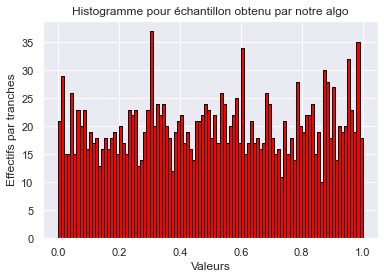

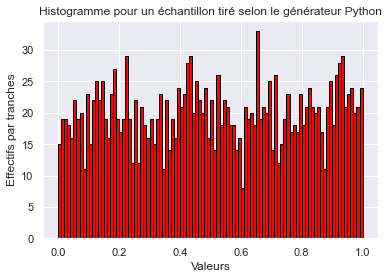

In [163]:
# Visulaisation de l'adéquation à la loi uniforme :

X=y[8000:,91]
plt.hist(X, range = (0, 1), bins = 100, color = 'red',edgecolor = 'black')
plt.xlabel('Valeurs')
plt.ylabel('Effectifs par tranches')
plt.title('Histogramme pour échantillon obtenu par notre algo')
plt.show()

Y=[rd.uniform(0,1) for i in range(8000,10000)]
plt.hist(Y, range = (0, 1), bins = 100, color = 'red',edgecolor = 'black')
plt.xlabel('Valeurs')
plt.ylabel('Effectifs par tranches')
plt.title("Histogramme pour un échantillon tiré selon le générateur Python")
plt.show()

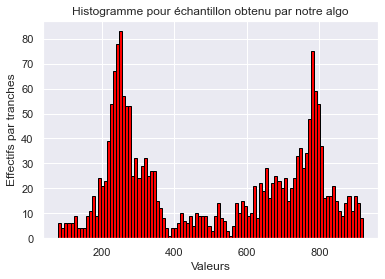

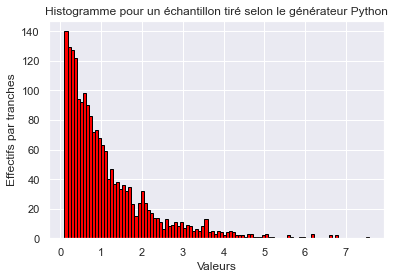

In [178]:
X=y[8000:,92]
plt.hist(X, bins = 100, color = 'red',edgecolor = 'black')
plt.xlabel('Valeurs')
plt.ylabel('Effectifs par tranches')
plt.title('Histogramme pour échantillon obtenu par notre algo')
plt.show()

Y=[scipy.stats.expon.rvs(0.1) for i in range(8000,10000)]
plt.hist(Y, bins = 100, color = 'red',edgecolor = 'black')
plt.xlabel('Valeurs')
plt.ylabel('Effectifs par tranches')
plt.title("Histogramme pour un échantillon tiré selon le générateur Python")
plt.show()

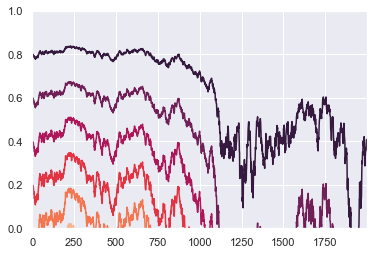

In [179]:
plt.contour([X,Y])

## Autocorrélations

In [193]:
# réinitialisation de notre vecteur y 
N = 10000
y = np.zeros((N, 93))

for i in range (0,91):
    y[0,i]=data['prob'][i]
y[0,91]=0.5
y[0,92]=5

w=np.zeros(N)
kap=np.zeros(N)
z=np.zeros(N)

for n in tqdm(range(1, 10000)):
    y[n] = metropolis_within_gibbs_bis(y[n-1],sigma_1=0.3,sigma_2=10)[0]

  0%|          | 0/9999 [00:00<?, ?it/s]<ipython-input-121-ac0d0879f009>:35: RuntimeWarning: overflow encountered in double_scalars
  quantite_2=((gammar(w)/gammar(w*y[91]))*(1/gammar(w*(1-y[91]))))**91
<ipython-input-121-ac0d0879f009>:39: RuntimeWarning: invalid value encountered in double_scalars
  seuil_kap=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
<ipython-input-121-ac0d0879f009>:20: RuntimeWarning: invalid value encountered in double_scalars
  seuil_mu=min(1,(quantite_1*quantite_3)/quantite_2)
<ipython-input-121-ac0d0879f009>:36: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=((gammar(kap)/gammar(kap*y[91]))*(1/gammar(kap*(1-y[91]))))**91
<ipython-input-121-ac0d0879f009>:19: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
<ipython-input-121-ac0d0879f009>:37: RuntimeWarning: overflow encountered in double_scalars
  quantite_4=(math.prod([y[i]/(1-y[i]) for i

Text(0.5, 1.0, 'Autocorrélation pour X0')

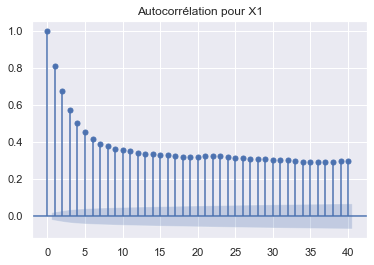

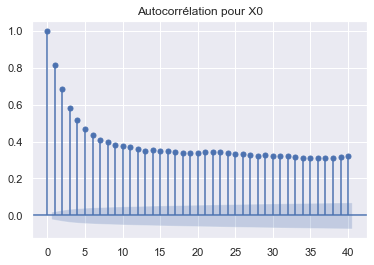

In [197]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y[:,1])
plt.title("Autocorrélation pour X1")

plot_acf(y[:,0])
plt.title("Autocorrélation pour X0")

In [202]:
def plot_MWG_ACF(sigma_1=0.3, sigma_2=10, dim=0):
    N = 10000
    y = np.zeros((N, 93))

    for i in range (0,91):
        y[0,i]=data['prob'][i]
    y[0,91]=0.5
    y[0,92]=5

    w=np.zeros(N)
    kap=np.zeros(N)
    z=np.zeros(N)
    # génération de la chaîne
    for n in tqdm(range(1, 10000)):
        y[n] = metropolis_within_gibbs_bis(y[n-1],sigma_1,sigma_2)[0]

    # plot
    plot_acf(y[:,dim])
    plt.title(f"Autocorrelation pour X{dim+1} avec sigma_1 = {sigma_1}, sigma_2 = {sigma_2}")
    return None


  0%|          | 0/999 [00:00<?, ?it/s]<ipython-input-121-ac0d0879f009>:35: RuntimeWarning: overflow encountered in double_scalars
  quantite_2=((gammar(w)/gammar(w*y[91]))*(1/gammar(w*(1-y[91]))))**91
<ipython-input-121-ac0d0879f009>:39: RuntimeWarning: invalid value encountered in double_scalars
  seuil_kap=min(1,(quantite_1*quantite_2*quantite_4*quantite_5)/quantite_3)
<ipython-input-121-ac0d0879f009>:36: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=((gammar(kap)/gammar(kap*y[91]))*(1/gammar(kap*(1-y[91]))))**91
<ipython-input-121-ac0d0879f009>:20: RuntimeWarning: invalid value encountered in double_scalars
  seuil_mu=min(1,(quantite_1*quantite_3)/quantite_2)
<ipython-input-121-ac0d0879f009>:19: RuntimeWarning: overflow encountered in double_scalars
  quantite_3=(math.prod([y[i]/(1-y[i]) for i in range(0,91)]))**(kap*(z-mu))
<ipython-input-121-ac0d0879f009>:37: RuntimeWarning: overflow encountered in double_scalars
  quantite_4=(math.prod([y[i]/(1-y[i]) for i 

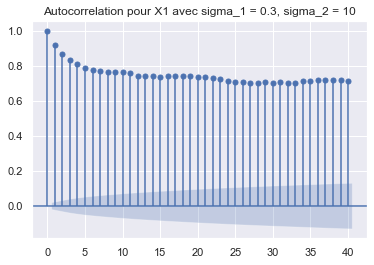

In [203]:
plot_MWG_ACF(0.3, 10, 0)